In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [2]:
# Cargar los datos desde el archivo CSV en Github
url = "https://raw.githubusercontent.com/JoaZ94/Amazon-Review-Sentiment-Classification/main/amazon_reviews.csv"
data = pd.read_csv(url)

In [3]:
# EDA (Exploratory Data Analysis)
# Revisar las primeras filas del dataset
display(data.head(5))

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [4]:
# Obtener información general sobre el dataset
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


None

In [5]:
# Obtener estadísticas descriptivas del dataset
display(data.describe())

,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,2457.000000,4.587589,437.367040,1.311089,0.210376,1.521465,1.100712,0.075468,0.020053
std,1418.982617,0.996845,209.439871,41.619161,4.023296,44.123095,39.367949,0.256062,0.077187
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-130.000000,0.000000,0.000000
25%,1228.500000,5.000000,281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2457.000000,5.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3685.500000,5.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4914.000000,5.000000,1064.000000,1952.000000,183.000000,2020.000000,1884.000000,1.000000,0.957544


In [6]:
valores_unicos = data['overall'].unique()
print(valores_unicos)

[4. 5. 3. 1. 2.]


In [7]:
# Contar la frecuencia de cada valor único en la columna 'overall'
value_counts = data['overall'].value_counts().sort_index()
value_counts

,count
overall,
1.0,244
2.0,80
3.0,142
4.0,527
5.0,3922


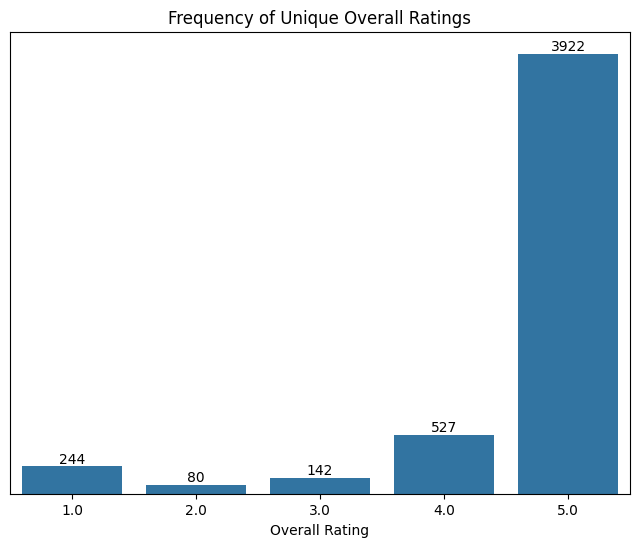

In [8]:
# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)

# Agregar etiquetas con la frecuencia en cada barra
for index, value in enumerate(value_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Configurar el gráfico
plt.xlabel('Overall Rating')
plt.ylabel('')  # Dejar el eje Y vacío para que no se muestre la etiqueta
plt.title('Frequency of Unique Overall Ratings')
plt.gca().axes.yaxis.set_visible(False)  # Ocultar el eje Y
plt.show()

In [9]:
# Verificar valores nulos
print(data.isnull().sum())

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


In [10]:
# Eliminar registros con valores nulos o vacíos en la columna 'reviewText'
data = data.dropna(subset=['reviewText'])  # Elimina filas con NaN en 'reviewText'
data = data[data['reviewText'].str.strip() != '']  # Elimina filas con 'reviewText' vacío

In [11]:
# Verificar que no queden registros vacíos
print(data['reviewText'].isnull().sum())
print(data['reviewText'].str.strip().eq('').sum())

0
0


In [12]:
# Convertir las etiquetas (calificación) a valores binarios (positivo (1)/negativo (0))
data['sentiment'] = data['overall'].apply(lambda x: 1 if x > 3 else 0)

In [13]:
# Contar la frecuencia de cada valor único en la columna 'overall'
sentiment_counts = data['sentiment'].value_counts().sort_index()
sentiment_counts

,count
sentiment,
0,466
1,4448


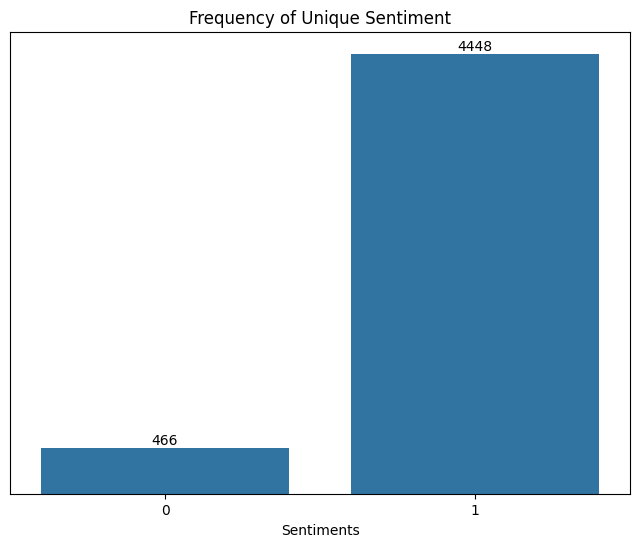

In [14]:
# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Agregar etiquetas con la frecuencia en cada barra
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Configurar el gráfico
plt.xlabel('Sentiments')
plt.ylabel('')  # Dejar el eje Y vacío para que no se muestre la etiqueta
plt.title('Frequency of Unique Sentiment')
plt.gca().axes.yaxis.set_visible(False)  # Ocultar el eje Y
plt.show()

In [15]:
# identificación de la clase Mayoritaria y Minoritaria de la variable de salida 'Sentiment'
majority_class = data[data['sentiment'] == 1]
print(f"Número de muestras en la clase mayoritaria: {len(majority_class)}")
minority_class = data[data['sentiment'] == 0]
print(f"Número de muestras en la clase minoritaria: {len(minority_class)}")

Número de muestras en la clase mayoritaria: 4448
Número de muestras en la clase minoritaria: 466


In [16]:
# Sobremuestrear la clase minoritaria (Oversampling)
minority_class_upsampled = resample(minority_class,
                                    replace=True,    # Hacer muestreo con reemplazo
                                    n_samples=len(majority_class),  # Igualar el número de muestras a la clase mayoritaria
                                    random_state=1)

In [17]:
len(minority_class_upsampled)

4448

In [18]:
len(majority_class)

4448

In [19]:
# Combinar clases sobremuestreadas
balanced_data = pd.concat([majority_class, minority_class_upsampled])

In [20]:
len(balanced_data)

8896

In [21]:
# Mezclar el dataset
balanced_data = balanced_data.sample(frac=1, random_state=1).reset_index(drop=True)
balanced_data.head(5)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,sentiment
0,1922,Happy Dad,5.0,There is not much to review other than how it ...,2013-10-30,404,0,0,0,0,0.0,0.0,1
1,3462,Norm D. Plume,1.0,Purchased for my android phone to provide more...,2013-05-31,556,0,0,0,0,0.0,0.0,0
2,3679,ProPhotog,2.0,"For the first two months, the card worked grea...",2013-05-26,561,0,0,0,0,0.0,0.0,0
3,3533,PA Pete,5.0,"Hasn't even blinked in my MP3 player, and gave...",2013-08-12,483,0,0,0,0,0.0,0.0,1
4,3504,One Day,1.0,THIS CARD DIED IN LESS THAN ONE MONTH IN MY SI...,2012-11-27,741,0,2,2,-2,0.0,0.0,0


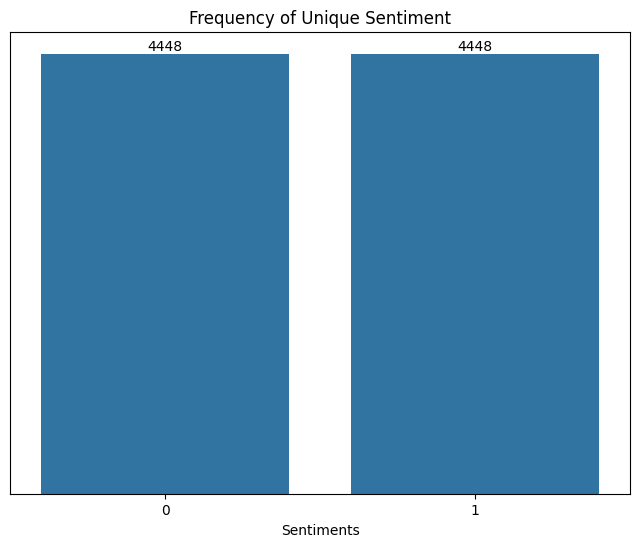

In [22]:
# Contar la frecuencia de cada valor único en la columna 'overall'
sentiment_counts = balanced_data['sentiment'].value_counts().sort_index()
sentiment_counts

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Agregar etiquetas con la frecuencia en cada barra
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Configurar el gráfico
plt.xlabel('Sentiments')
plt.ylabel('')  # Dejar el eje Y vacío para que no se muestre la etiqueta
plt.title('Frequency of Unique Sentiment')
plt.gca().axes.yaxis.set_visible(False)  # Ocultar el eje Y
plt.show()

In [23]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
def preprocess_text(text):
  # Convertir a minúsculas y eliminar puntuación
  text = re.sub(r'[^\w\s]', '', text.lower())

  # Tokenización
  tokens = nltk.word_tokenize(text)

  # Remoción de stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token not in stop_words]

  # Lematización
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return ' '.join(tokens)

In [25]:
# Preprocesamiento de Texto
balanced_data['preprocessed_text'] = balanced_data['reviewText'].apply(preprocess_text)

In [26]:
# Tokenización del texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_data['preprocessed_text'])
word_index = tokenizer.word_index

In [27]:
display(word_index)

{'card': 1,
 'phone': 2,
 'sandisk': 3,
 'work': 4,
 'one': 5,
 'memory': 6,
 'sd': 7,
 'problem': 8,
 'galaxy': 9,
 'would': 10,
 'use': 11,
 'speed': 12,
 'great': 13,
 'get': 14,
 'samsung': 15,
 'bought': 16,
 'file': 17,
 'time': 18,
 'month': 19,
 'product': 20,
 'got': 21,
 'good': 22,
 'class': 23,
 'device': 24,
 'read': 25,
 'format': 26,
 'camera': 27,
 'even': 28,
 'issue': 29,
 'fast': 30,
 'using': 31,
 'video': 32,
 'data': 33,
 'worked': 34,
 'well': 35,
 '10': 36,
 'price': 37,
 'amazon': 38,
 '2': 39,
 'like': 40,
 'storage': 41,
 'write': 42,
 'music': 43,
 'adapter': 44,
 'gb': 45,
 'used': 46,
 'tablet': 47,
 '3': 48,
 'computer': 49,
 'new': 50,
 'buy': 51,
 'tried': 52,
 'dont': 53,
 'say': 54,
 'micro': 55,
 'ive': 56,
 'fine': 57,
 'back': 58,
 'im': 59,
 '32gb': 60,
 'note': 61,
 'microsd': 62,
 'still': 63,
 'could': 64,
 'picture': 65,
 'need': 66,
 '64gb': 67,
 'put': 68,
 'brand': 69,
 'never': 70,
 'lot': 71,
 'first': 72,
 'another': 73,
 'day': 74,
 'tr

In [28]:
# Convertir las reseñas a secuencias de enteros
sequences = tokenizer.texts_to_sequences(balanced_data['preprocessed_text'])
print(sequences)

[[87, 81, 4, 99, 2024, 619, 18, 30, 29, 646, 31, 27, 129, 1003, 3859, 399, 32, 380, 156, 13, 2168], [78, 102, 2, 958, 373, 41, 5, 266, 1439, 1019, 3, 585, 150, 888, 80, 287, 83, 385, 235, 74, 1368, 90, 38, 218, 119, 181, 1842, 223, 38, 225, 933, 2169, 79, 218, 365, 79, 1090, 4, 72, 477, 637, 2, 591, 17, 162, 908, 1471, 806, 1073, 247, 1091, 90, 319, 3, 229, 287, 181, 152, 177, 71, 18, 2170, 1574, 478, 128, 45, 33, 1401, 1333, 2171, 181, 79, 3, 4, 35, 99, 152, 59, 1004, 87, 1035, 493, 519, 60, 23, 88, 3, 216, 5, 23, 36, 10, 277, 129, 959, 287, 48, 114, 257, 38, 1202, 287, 2172, 14, 80, 5, 300, 686, 90, 365, 79], [72, 82, 19, 1, 34, 13, 89, 219, 48, 293, 449, 5, 1402, 308, 168, 76, 38, 199, 120, 58, 56, 21, 687, 3, 101, 14, 229, 59, 2605, 106, 11, 27, 489, 113], [706, 28, 5426, 432, 325, 267, 647, 423, 2794, 1250, 546, 3, 309, 1756, 2025], [1, 154, 164, 5, 19, 509, 93, 2173, 65, 934, 65, 296, 51], [55, 7, 44, 4, 57, 394, 5, 108, 10, 420, 113, 164, 175, 1440, 178, 238, 1543, 415], [23, 36

In [29]:
# Rellenar las secuencias para que tengan la misma longitud
max_len = max([len(seq) for seq in sequences])
print(f"El tamaño máximo de las review es de: {max_len}")
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

El tamaño máximo de las review es de: 812


In [30]:
print(padded_sequences)

[[  87   81    4 ...    0    0    0]
 [  78  102    2 ...    0    0    0]
 [  72   82   19 ...    0    0    0]
 ...
 [ 267    9   97 ...    0    0    0]
 [ 122    1 4200 ...    0    0    0]
 [  20    4  269 ...    0    0    0]]


In [31]:
X = padded_sequences
y = balanced_data['sentiment'].values

In [32]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Crear el modelo de red neuronal usando Tensorflow
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [34]:
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Definir un callback para detener el entrenamiento si la precisión no mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [37]:
# Entrenar el modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.6651 - loss: 0.5773 - val_accuracy: 0.9331 - val_loss: 0.1771
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.9663 - loss: 0.1219 - val_accuracy: 0.9815 - val_loss: 0.0714
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.9926 - loss: 0.0339 - val_accuracy: 0.9809 - val_loss: 0.0756
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - accuracy: 0.9956 - loss: 0.0208 - val_accuracy: 0.9860 - val_loss: 0.0678
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.9993 - loss: 0.0055 - val_accuracy: 0.9843 - val_loss: 0.0797
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.9860 - val_loss: 0.0794
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 1.0000 - loss: 4.7624e-04 - val_accuracy: 0.9848 - val_loss: 0.0968


In [38]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9858 - loss: 0.0973
Precisión en el conjunto de prueba: 98.48%


In [39]:
# Realizar predicciones en todo el conjunto de prueba
predictions = model.predict(X_test)
predicted_classes = [1 if prob >= 0.5 else 0 for prob in predictions]

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


In [40]:
# Convertir las secuencias de X_test de vuelta a texto
text_sequences = tokenizer.sequences_to_texts(X_test)

In [41]:
# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'ReviewText': text_sequences,
    'ExpectedOutput': y_test,
    'PredictedOutput': predicted_classes,
    'PredictionConfidence': predictions.flatten()
})

In [42]:
# Mostrar el DataFrame resultante
display(results_df.head(10))

,ReviewText,ExpectedOutput,PredictedOutput,PredictionConfidence
0,best best best productreliableown fewone isnt ...,1,1,0.999998
1,working three card using included adapter thou...,0,0,0.000004
2,acquired card month ago use phone samsung gala...,0,0,0.000006
3,worked gopro say except wonder fit 64 gig smal...,1,1,0.999982
4,broke 2 weeksi go back samsung hd card waste t...,0,0,0.000015
5,good price working well used galaxy s3 s4 note...,1,1,0.999996
6,best memory found consistency high speed ideal...,1,1,0.999993
7,great microsdhc c10uhs1 disk memory card adapt...,1,1,0.999998
8,work card purchased best buy look identical si...,0,0,0.000008
9,even though say review 32gb version 64gb sure ...,0,0,0.000005


In [43]:
results_df.loc[4, 'ReviewText']

'broke 2 weeksi go back samsung hd card waste time money actually ask refund'

In [44]:
# Guardar el DataFrame en un archivo CSV si es necesario
#results_df.to_csv('model_predictions.csv', index=False)

In [45]:
# Guardar el modelo entrenado
joblib.dump(model, 'sentiment_analysis_binary_model.pkl')

['sentiment_analysis_binary_model.pkl']

In [46]:
# Predicción de sentimiento en una reseña nueva
def predict_sentiment(review):

    # Limpiar el texto (asumiendo que preprocess_text es una función que ya tienes definida)
    review_cleaned = preprocess_text(review)
    # Convertir el texto a secuencia de tokens
    review_sequence = tokenizer.texts_to_sequences([review_cleaned])
    # Asegurarse de que la secuencia tenga la longitud adecuada
    review_padded = pad_sequences(review_sequence, maxlen=max_len, padding='post')
    # Hacer la predicción
    prediction = model.predict(review_padded)
    print(prediction)
    # Devolver la categoría de sentimiento basada en el umbral de 0.5
    return 'Positivo' if prediction > 0.5 else 'Negativo'

In [47]:
# Ejemplo de predicción de reseña positiva
review = "I recently bought the XYZ Bluetooth Speaker, and I couldn't be happier with my purchase! The sound quality is amazing for such a compact device, and the battery life lasts all day. The connection is stable, and it pairs quickly with my phone. Highly recommend it for anyone looking for a portable and reliable speaker."
print(f"Sentimiento de la reseña: {predict_sentiment(review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
[[0.999997]]
Sentimiento de la reseña: Positivo


In [48]:
# Ejemplo de predicción positiva
review = "I purchased the ABC Electric Kettle a few weeks ago. It heats water quickly and looks nice on my countertop. However, the lid doesn't always close properly, which is a bit annoying. Overall, it gets the job done, but it could use some improvements in the design."
print(f"Sentimiento de la reseña: {predict_sentiment(review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
[[0.9999963]]
Sentimiento de la reseña: Positivo


In [49]:
# Ejemplo de predicción negativa
review = "I bought the MNO Smartphone, and it's been a frustrating experience from the start. The battery drains incredibly fast, barely lasting half a day even with minimal use. The camera quality is terrible, producing grainy and washed-out photos. The phone constantly freezes and crashes, making basic tasks like texting or browsing a nightmare. I've also noticed that the touchscreen is unresponsive at times. Overall, this phone is not worth the money, and I regret purchasing it."
print(f"Sentimiento de la reseña: {predict_sentiment(review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[[3.2932167e-05]]
Sentimiento de la reseña: Negativo


In [50]:
# Ejemplo de predicción negativa
review = "I bought the DEF Wireless Earbuds, and I'm really disappointed. The sound quality is subpar, and they constantly lose connection with my phone. The battery also dies much faster than advertised. I wouldn't recommend these to anyone looking for a dependable pair of earbuds."
print(f"Sentimiento de la reseña: {predict_sentiment(review)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
[[0.00224391]]
Sentimiento de la reseña: Negativo
